## Experiment with flight data APIs

Initial goal: compare deterministic optimal (cheapest) flight search to agent-driven one

In [1]:
from utils.utils import get_flights_to_destinations, plot_price_distribution

import nest_asyncio
nest_asyncio.apply()

import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv()

from openai import AsyncOpenAI
client = AsyncOpenAI()

from IPython.display import Markdown, display

import warnings
warnings.filterwarnings("ignore")

Test query with the function

In [2]:
flights_df = get_flights_to_destinations(
    date="2025-06-02",
    from_airport="EWR",
    to_airports=[
        "ORY",  # Orly
        "CDG",  # Charles de Gaulle
    ],
    max_stops=1,
    #trip="one-way",
    #passengers_adults=2,
)

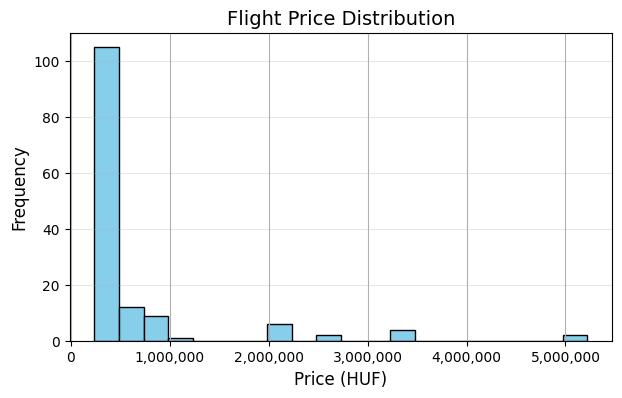

In [3]:
fig = plot_price_distribution(flights_df)

In [4]:
flights_df.head(3)

,price,departure_date,departure_time,arrival_date,arrival_time,duration_hours,name,stops,is_best,price_denomination,destination_airport
0,236152,2025-06-02,01:15,2025-06-02,14:30,7.25,French bee,0,True,HUF,ORY
1,236152,2025-06-02,23:00,2025-06-03,12:15,7.25,French bee,0,True,HUF,ORY
2,268377,2025-06-02,22:50,2025-06-03,15:50,NaN,Tap Air Portugal,1,True,HUF,ORY


### General tool-calling agent

Showcasing tool calling capabilities by assigning the above function as a tool to an OpenAI model. Tool will return with the pandas under the hood, the AI will analyze the content and provide an answer

1. Set up custom tool

In [2]:
from agents import WebSearchTool
from utils.tools import get_flights_to_destinations_tool, add_tool
from utils.prompts import system_message, user_message_template
from utils.ai import ai, conversation

2. Set up `ai` args

In [6]:
payload = {
    "agent_name": "Flight Assistant",
    "system_message": system_message,
    "user_message_template": user_message_template,
    "tools": [get_flights_to_destinations_tool, add_tool, WebSearchTool()],
    "stream": True,
    "model": "gpt-4.1",
    "format_to_md": True
}

Simple test

In [4]:
q = 'first, tell me what 4 + 10 is using the add tool, then tell me what is the difference between declarative and imperative?'
a = await ai(q, **payload)

The result of 4 + 10 is 14.

Now, to answer your second question:
- Declarative and imperative are two major programming paradigms:
  - Declarative programming focuses on describing what you want to achieve, without specifying the exact steps to do it. Examples include SQL (for databases) and HTML (for structure of webpages). You state the desired outcome.
  - Imperative programming is about describing how to achieve a result, step by step. You explicitly tell the computer what to do and how to do it. Languages like C, Java, and Python are commonly used in this paradigm.

In short: Declarative = what, Imperative = how.

Tool add_tool called with arguments: {"a":4,"b":10}
Tool call 3j6k9Ej0bF33MU6CkJ0an3sn returned with results: 14


In [7]:
display(Markdown(a.final_output))

The result of 4 + 10 is 14.

Now, to answer your second question:
- Declarative and imperative are two major programming paradigms:
  - Declarative programming focuses on describing what you want to achieve, without specifying the exact steps to do it. Examples include SQL (for databases) and HTML (for structure of webpages). You state the desired outcome.
  - Imperative programming is about describing how to achieve a result, step by step. You explicitly tell the computer what to do and how to do it. Languages like C, Java, and Python are commonly used in this paradigm.

In short: Declarative = what, Imperative = how.

In [ ]:
q = 'first, tell me what 4 + 10 is using the add tool, then search for latest sp500 news'
a = await ai(q, **payload)

Test with flight related question

In [7]:
q = 'cheap flights budapest madrid tomorrow'
a = await ai(q, **payload)

Here are the cheapest flight options from Budapest (BUD) to Madrid (MAD) for tomorrow, April 22, 2025:

### Cheapest Direct Flights
- **Ryanair**
  - Price: 214,598 HUF
  - Departure: 20:10 | Arrival: 23:30 (3h 20m nonstop)
  - This is the best deal for a direct flight.
- **Wizz Air**
  - Price: 248,130 HUF
  - Departure: 16:00 | Arrival: 19:30 (3h 30m nonstop)
- **Iberia**
  - Price: 405,800 HUF
  - Departure: 15:30 | Arrival: 18:50 (3h 20m nonstop)

### Cheapest 1-Stop (Connecting) Flights
- **Brussels Airlines**
  - Price: 370,400 HUF
  - Departure: 06:35 | Arrival: 11:50 (5h 15m, 1 stop)
- **Self Transfer (multiple airlines)**
  - Price: 224,614 HUF
  - Departure: 13:05 | Arrival: Next day—12:10 (23h 5m, 1 stop)
  - Long layover, but can sometimes offer better flexibility.

### Price Distribution
- **Cheapest direct flight:** 214,598 HUF (Ryanair, evening).
- **Average price for direct flights:** 214,000–405,800 HUF.
- **Premium/premium economy options:** Often exceed 800,000 HUF, with business class and traditional airlines (KLM, British Airways, Lufthansa) ranging from ~838,400 HUF to over 1,250,000 HUF.

### Recommendations:
- For best value and convenience, Ryanair’s direct flight at 20:10 is recommended.
- For a slightly earlier direct flight, Wizz Air at 16:00 is another solid choice, at a modest price increase.
- If a morning departure is needed and you don’t mind one stop, Brussels Airlines at 06:35 offers a good compromise.

Would you like details on baggage, seat selection, or how to book? Let me know your preferences!

Tool get_flights_to_destinations_tool called with arguments: {"date":"2025-04-22","from_airport":"BUD","to_airports":["MAD"],"max_stops":1}
Tool call C4DNBxjLdaRtpHTQrb6fber9 returned with results:       price departure_date departure_time arrival_date arrival_time  \
0    214598     2025-04-22          20:10   2025-04-22        23:30   
1    248130     2025-04-22          16:00   2025-04-22        19:30   
2    370400     2025-04-22          0


In [8]:
display(Markdown(a.final_output))

Here are the cheapest flight options from Budapest (BUD) to Madrid (MAD) for tomorrow, April 22, 2025:

### Cheapest Direct Flights
- **Ryanair**
  - Price: 214,598 HUF
  - Departure: 20:10 | Arrival: 23:30 (3h 20m nonstop)
  - This is the best deal for a direct flight.
- **Wizz Air**
  - Price: 248,130 HUF
  - Departure: 16:00 | Arrival: 19:30 (3h 30m nonstop)
- **Iberia**
  - Price: 405,800 HUF
  - Departure: 15:30 | Arrival: 18:50 (3h 20m nonstop)

### Cheapest 1-Stop (Connecting) Flights
- **Brussels Airlines**
  - Price: 370,400 HUF
  - Departure: 06:35 | Arrival: 11:50 (5h 15m, 1 stop)
- **Self Transfer (multiple airlines)**
  - Price: 224,614 HUF
  - Departure: 13:05 | Arrival: Next day—12:10 (23h 5m, 1 stop)
  - Long layover, but can sometimes offer better flexibility.

### Price Distribution
- **Cheapest direct flight:** 214,598 HUF (Ryanair, evening).
- **Average price for direct flights:** 214,000–405,800 HUF.
- **Premium/premium economy options:** Often exceed 800,000 HUF, with business class and traditional airlines (KLM, British Airways, Lufthansa) ranging from ~838,400 HUF to over 1,250,000 HUF.

### Recommendations:
- For best value and convenience, Ryanair’s direct flight at 20:10 is recommended.
- For a slightly earlier direct flight, Wizz Air at 16:00 is another solid choice, at a modest price increase.
- If a morning departure is needed and you don’t mind one stop, Brussels Airlines at 06:35 offers a good compromise.

Would you like details on baggage, seat selection, or how to book? Let me know your preferences!

In [9]:
a.new_items

[ToolCallItem(agent=Agent(name='Flight Assistant', instructions="You are a helpful personal assistant. You are able to get real-time flight information for a given destination and date. You answer users' questions about flight prices and availability.", handoff_description=None, handoffs=[], model='gpt-4.1', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=False, truncation=None, max_tokens=None), tools=[FunctionTool(name='get_flights_to_destinations_tool', description='Fetch flights to multiple destinations and return a combined DataFrame.', params_json_schema={'properties': {'date': {'description': 'Flight date in YYYY-MM-DD format', 'title': 'Date', 'type': 'string'}, 'from_airport': {'description': 'Departure airport code in IATA format (3-letter codes), such as "BUD"', 'title': 'From Airport', 'type': 'string'}, 'to_airports': {'description': 'List of destination airport codes in IATA fo

In [10]:
a.raw_responses

[ModelResponse(output=[ResponseFunctionToolCall(id='fc_680641537f448192b303ae875ebfa60e0b8d84e233da1ea9', arguments='{"date":"2025-04-22","from_airport":"BUD","to_airports":["MAD"],"max_stops":1}', call_id='call_C4DNBxjLdaRtpHTQrb6fber9', name='get_flights_to_destinations_tool', type='function_call', status='completed')], usage=Usage(requests=1, input_tokens=674, output_tokens=45, total_tokens=719), referenceable_id='resp_6806415281f48192b3239c2bb024cfcb0b8d84e233da1ea9'),
 ModelResponse(output=[ResponseOutputMessage(id='msg_68064157f0bc81928c139a41353972070b8d84e233da1ea9', content=[ResponseOutputText(annotations=[], text='Here are the cheapest flight options from Budapest (BUD) to Madrid (MAD) for tomorrow, April 22, 2025:\n\n### Cheapest Direct Flights\n- **Ryanair**\n  - Price: 214,598 HUF\n  - Departure: 20:10 | Arrival: 23:30 (3h 20m nonstop)\n  - This is the best deal for a direct flight.\n- **Wizz Air**\n  - Price: 248,130 HUF\n  - Departure: 16:00 | Arrival: 19:30 (3h 30m nons

Complex question

In [43]:
model_for_complex_question = 'o1'

q = 'I want to find the best deal for flying to Madeira from Budapest any time between 2025-07-01 and 2025-07-15. I will want to spend at least 5, at most 8 days there. I will be traveling with my girlfriend. Ideally I only want to have at most 1 stop. Find the optimal flight for me. I want to have the cheapest flight possible.'

a = await ai(q, **payload.update({"model": model_for_complex_question}))

In [ ]:
display(Markdown(a.final_output))

In [ ]:
a.new_items

#### Implement conversation memory

In [3]:
payload = {
    "agent_name": "Flight Assistant",
    "system_message": system_message,
    "user_message_template": user_message_template,
    "tools": [get_flights_to_destinations_tool, add_tool, WebSearchTool()],
    "stream": True,
    "model": "gpt-4.1",
    "format_to_md": False
}

In [ ]:
await conversation(payload)

### Try manual price checks

In [5]:
def find_cheapest_round_trip(
    outbound_date: str,
    total_travel_time_min: int,
    total_travel_time_max: int,
    outbound_date_flexibility: int,
    from_airport: str,
    to_airports: list[str],
    max_stops: int = 1
) -> pd.DataFrame:
    """
    Find round trip flights based on flexible dates and travel duration.
    
    Args:
        outbound_date (str): Starting date for outbound flight in format 'YYYY-MM-DD'.
        total_travel_time_min (int): Minimum number of days for the trip.
        total_travel_time_max (int): Maximum number of days for the trip.
        outbound_date_flexibility (int): Number of days to check after the outbound date.
        from_airport (str): Departure airport code.
        to_airports (list): List of destination airport codes.
        max_stops (int): Maximum number of stops allowed.
        
    Returns:
        pd.DataFrame: A DataFrame with all flight combinations tried, 
                      sorted by total price. Includes dates, destination airports, prices, etc.
    """
    
    outbound_date_dt = datetime.strptime(outbound_date, "%Y-%m-%d")
    flight_combinations = []
    
    for outbound_offset in tqdm(range(outbound_date_flexibility + 1), desc="Checking outbound dates"):
        current_outbound_date = outbound_date_dt + timedelta(days=outbound_offset)
        current_outbound_str = current_outbound_date.strftime("%Y-%m-%d")
        
        outbound_flights_data = get_flights_to_destinations(
            date=current_outbound_str,
            from_airport=from_airport,
            to_airports=to_airports,
            max_stops=max_stops
        )
        
        if outbound_flights_data.empty:
            continue
            
        for travel_days in tqdm(range(total_travel_time_min, total_travel_time_max + 1), 
                               desc=f"Checking return dates for outbound {current_outbound_str}", 
                               leave=False):
            return_date = current_outbound_date + timedelta(days=travel_days)
            return_date_str = return_date.strftime("%Y-%m-%d")
            
            for dest_airport_candidate in outbound_flights_data['destination_airport'].unique():
                
                current_outbound_flights_to_dest = outbound_flights_data[
                    outbound_flights_data['destination_airport'] == dest_airport_candidate
                ]
                if current_outbound_flights_to_dest.empty:
                    continue

                min_outbound_price = current_outbound_flights_to_dest['price'].min()
                cheapest_outbound = current_outbound_flights_to_dest.loc[
                    current_outbound_flights_to_dest['price'] == min_outbound_price
                ].iloc[0]
                
                return_flights_data = get_flights_to_destinations(
                    date=return_date_str,
                    from_airport=dest_airport_candidate,
                    to_airports=[from_airport], 
                    max_stops=max_stops
                )
                
                if return_flights_data.empty:
                    continue
                    
                min_return_price = return_flights_data['price'].min()
                cheapest_return = return_flights_data.loc[
                    return_flights_data['price'] == min_return_price
                ].iloc[0]
                
                total_price = min_outbound_price + min_return_price
                
                flight_combinations.append({
                    'outbound_date': current_outbound_str,
                    'return_date': return_date_str,
                    'travel_days': travel_days,
                    'destination_airport': dest_airport_candidate,
                    'total_price': total_price,
                    'outbound_price': min_outbound_price,
                    'return_price': min_return_price,
                    'outbound_airline': cheapest_outbound['name'],
                    'return_airline': cheapest_return['name'],
                    'outbound_stops': cheapest_outbound['stops'],
                    'return_stops': cheapest_return['stops'],
                    'outbound_duration': cheapest_outbound['duration_hours'],
                    'return_duration': cheapest_return['duration_hours'],
                })
    
    if not flight_combinations:
        return pd.DataFrame()
    
    combinations_df = pd.DataFrame(flight_combinations)
    combinations_df = combinations_df.sort_values('total_price').reset_index(drop=True)
    
    return combinations_df

In [9]:
# Example usage:
all_combinations = find_cheapest_round_trip(
    outbound_date="2025-07-10",
    total_travel_time_min=10,
    total_travel_time_max=10,
    outbound_date_flexibility=2,
    from_airport="BUD",
    to_airports=["LAX", "SFO"],
    max_stops=2
)

Checking outbound dates: 100%|██████████| 3/3 [00:25<00:00,  8.42s/it]


In [10]:
all_combinations.sort_values(['total_price']).head(10)

,outbound_date,return_date,travel_days,destination_airport,total_price,outbound_price,return_price,outbound_airline,return_airline,outbound_stops,return_stops,outbound_duration,return_duration
0,2025-07-12,2025-07-22,10,LAX,654003,367400,286603,"Finnair, American","American, British Airways",2,1,34.333,18.500
1,2025-07-10,2025-07-20,10,LAX,728203,441600,286603,"Aer Lingus, American","American, British Airways",2,1,20.050,18.750
2,2025-07-11,2025-07-21,10,LAX,750203,463600,286603,"Austrian, United",British Airways,2,1,20.600,20.167
3,2025-07-10,2025-07-20,10,SFO,859763,544600,315163,"Finnair, Alaska",British Airways,2,1,19.583,23.667
4,2025-07-11,2025-07-21,10,SFO,925930,600200,325730,"KLM, Delta",Air France,2,1,20.367,22.917
5,2025-07-12,2025-07-22,10,SFO,928763,613600,315163,"Austrian, United",British Airways,2,1,20.733,23.417


Combination across Europe - from Budapest

In [6]:
# Example usage:
all_combinations_europe = find_cheapest_round_trip(
    outbound_date="2025-08-15",
    total_travel_time_min=3,
    total_travel_time_max=8,
    outbound_date_flexibility=10,  # Covers Aug 15 to Aug 25
    from_airport="BUD",
    to_airports=[
        "SVQ",  # Sevilla
        "VLC",  # Valencia
        "AGP",  # Malaga
        "GRX",  # Granada
        "XRY",  # Jerez
        "LEI",  # Almeria
        "BOD",  # Bordeaux
        "TLS",  # Toulouse
        "BRI",  # Bari
        "NAP",  # Naples
        "CTA",  # Catania
        "KEF",  # Iceland (Keflavik)
        "DUB",  # Ireland (Dublin)
        "OSL",  # Norway (Oslo)
        "HEL",  # Finland (Helsinki)
        "ARN",  # Sweden (Stockholm Arlanda)
        "BIO",  # Bilbao
        "SCQ",  # Santiago de Compostela
        "OVD",  # Asturias/Oviedo
        "PMI",  # Palma de Mallorca
        "IBZ",  # Ibiza
        "MAH"   # Menorca
    ],
    max_stops=1
)

Checking outbound dates:   0%|          | 0/11 [00:00<?, ?it/s]

Checking outbound dates: 100%|██████████| 11/11 [1:17:13<00:00, 421.21s/it]


In [7]:
all_combinations_europe.sort_values(['total_price'])

,outbound_date,return_date,travel_days,destination_airport,total_price,outbound_price,return_price,outbound_airline,return_airline,outbound_stops,return_stops,outbound_duration,return_duration
0,2025-08-25,2025-09-01,7,NAP,59177,35304,23873,Ryanair,Wizz Air,0,0,1.667,1.750
1,2025-08-25,2025-08-28,3,NAP,62072,35304,26768,Ryanair,Wizz Air,0,0,1.667,1.750
2,2025-08-25,2025-09-02,8,NAP,62072,35304,26768,Ryanair,Wizz Air,0,0,1.667,1.750
3,2025-08-20,2025-08-24,4,ARN,66398,44432,21966,Ryanair,Ryanair,0,0,2.333,2.333
4,2025-08-20,2025-08-28,8,NAP,68898,42130,26768,Ryanair,Wizz Air,0,0,1.667,1.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,2025-08-25,2025-08-30,5,GRX,678874,450600,228274,Iberia,Iberia,1,1,21.667,17.167
1437,2025-08-24,2025-09-01,8,GRX,682582,353800,328782,Iberia,Iberia,1,1,21.667,21.167
1438,2025-08-25,2025-08-31,6,GRX,684623,450600,234023,Iberia,Iberia,1,1,21.667,5.583
1439,2025-08-25,2025-09-01,7,GRX,779382,450600,328782,Iberia,Iberia,1,1,21.667,21.167


In [ ]:
all_combinations_europe.sort_values(['total_price'])

In [9]:
all_combinations_europe.loc[all_combinations_europe.groupby('destination_airport')['total_price'].idxmin()]

,outbound_date,return_date,travel_days,destination_airport,total_price,outbound_price,return_price,outbound_airline,return_airline,outbound_stops,return_stops,outbound_duration,return_duration
350,2025-08-21,2025-08-27,6,AGP,138129,73136,64993,Wizz Air,Ryanair,0,0,3.750,3.417
3,2025-08-20,2025-08-24,4,ARN,66398,44432,21966,Ryanair,Ryanair,0,0,2.333,2.333
306,2025-08-16,2025-08-19,3,BIO,134320,65156,69164,Wizz Air,Wizz Air,0,0,NaN,2.917
788,2025-08-17,2025-08-20,3,BOD,248325,141200,107125,Lufthansa,Air France,1,1,11.583,12.333
14,2025-08-25,2025-09-01,7,BRI,76279,50798,25481,Ryanair,Ryanair,0,0,1.500,1.500
79,2025-08-25,2025-09-02,8,CTA,98335,54392,43943,Wizz Air,Ryanair,0,0,2.250,2.167
119,2025-08-20,2025-08-27,7,DUB,109043,74628,34415,Ryanair,Ryanair,0,0,3.167,2.833
945,2025-08-19,2025-08-26,7,GRX,310287,182400,127887,Iberia,Iberia,1,1,13.750,5.333
268,2025-08-20,2025-08-27,7,HEL,130980,71800,59180,Finnair,Finnair,0,0,2.333,2.333
524,2025-08-22,2025-08-28,6,IBZ,169026,101798,67228,Eurowings,"Transavia, KLM",1,1,10.250,NaN
